In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error

from calculate_exp_aa_subst_matrix import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities
)

In [2]:
coda = CodonAnnotation(1)

## Load spectrum and calculate expected AA subst matrix and equilibrium

In [4]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A']
spectrum_20A

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,20A,AtoC,286,17202,0.016626,A,0.289620,0.057407,A>C
1,20A,AtoG,1617,17202,0.094001,A,0.289620,0.324570,A>G
2,20A,AtoT,515,17202,0.029938,A,0.289620,0.103370,A>T
3,20A,CtoA,339,17202,0.019707,C,0.137040,0.143810,C>A
4,20A,CtoG,130,17202,0.007557,C,0.137040,0.055147,C>G
5,20A,CtoT,7113,17202,0.413500,C,0.137040,3.017400,C>T
6,20A,GtoA,837,17202,0.048657,G,0.064987,0.748720,G>A
7,20A,GtoC,137,17202,0.007964,G,0.064987,0.122550,G>C
8,20A,GtoT,2670,17202,0.155210,G,0.064987,2.388400,G>T
9,20A,TtoA,565,17202,0.032845,T,0.508360,0.064610,T>A


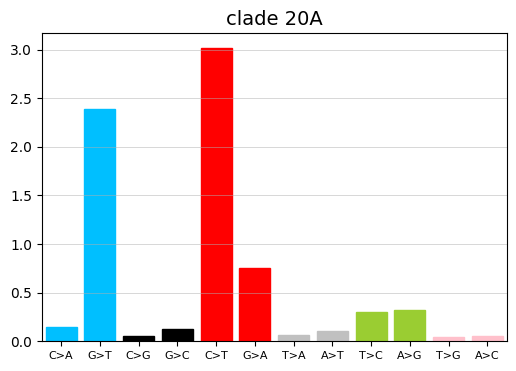

<Axes: title={'center': 'clade 20A'}>

In [100]:
plot_mutspec12(spectrum_20A, 'rate', 'clade 20A')

In [128]:
df_changes = collect_possible_changes(gc=1)
clade_specific_spectrum = spectrum_20A.set_index('Mut').rate.to_dict()

df_changes['rate'] = df_changes['sbs'].map(clade_specific_spectrum)
df_changes['aa1'] = df_changes['aa1'].map(amino_acid_codes)
df_changes['aa2'] = df_changes['aa2'].map(amino_acid_codes)

## Calculate expected AA substitutions matrix
exp_aa_subst = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
exp_aa_subst.to_csv('data/exp_aa_subst.csv', float_format='%g', index=False)
exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)


## Calculate codon and AA equilibrium frequencies
cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_cdn.to_csv('./data/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

,cdn,freq,aa
0,AAA,0.004267,Lys
1,AAC,0.001897,Asn
2,AAG,0.000726,Lys
3,AAT,0.019418,Asn
4,ACA,0.001897,Thr
...,...,...,...
59,TGT,0.015035,Cys
60,TTA,0.088360,Leu
61,TTC,0.039289,Phe
62,TTG,0.015035,Leu


In [129]:
exp_aa_subst_matrix

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,7.368244,0.000000,0.000000,0.287620,0.000000,0.000000,0.287620,0.220588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.490200,9.553600,2.994880,0.000000,0.00000,12.069600
Arg,0.000000,8.843968,0.000000,0.000000,6.034800,1.497440,0.000000,0.869728,1.497440,2.388400,9.553600,1.497440,2.388400,0.000000,0.490200,2.959347,0.245100,3.120770,0.00000,0.000000
Asn,0.000000,0.000000,3.314490,0.649140,0.000000,0.000000,0.000000,0.000000,0.114814,0.206740,0.000000,0.308737,0.000000,0.000000,0.000000,0.649140,0.114814,0.000000,0.20674,0.000000
Asp,0.114814,0.000000,1.497440,3.314490,0.000000,0.000000,0.308737,0.649140,0.245100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.77680,0.206740
Cys,0.000000,0.594180,0.000000,0.000000,3.314490,0.000000,0.000000,0.090340,0.000000,0.000000,0.000000,0.000000,0.000000,4.776800,0.000000,0.374320,0.000000,0.100317,1.49744,0.000000
Gln,0.000000,0.649140,0.000000,0.000000,0.000000,1.073290,0.110294,0.000000,2.671727,0.000000,0.206740,0.287620,0.000000,0.000000,0.114814,0.000000,0.000000,0.000000,0.00000,0.000000
Glu,0.114814,0.000000,0.000000,2.671727,0.000000,0.245100,1.073290,0.649140,0.000000,0.000000,0.000000,1.497440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.206740
Gly,0.490200,1.987640,0.000000,1.497440,4.776800,0.000000,1.497440,7.368244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.497440,0.000000,2.388400,0.00000,9.553600
His,0.000000,0.649140,0.287620,0.110294,0.000000,0.308737,0.000000,0.000000,3.314490,0.000000,0.206740,0.000000,0.000000,0.000000,0.114814,0.000000,0.000000,0.000000,6.03480,0.000000


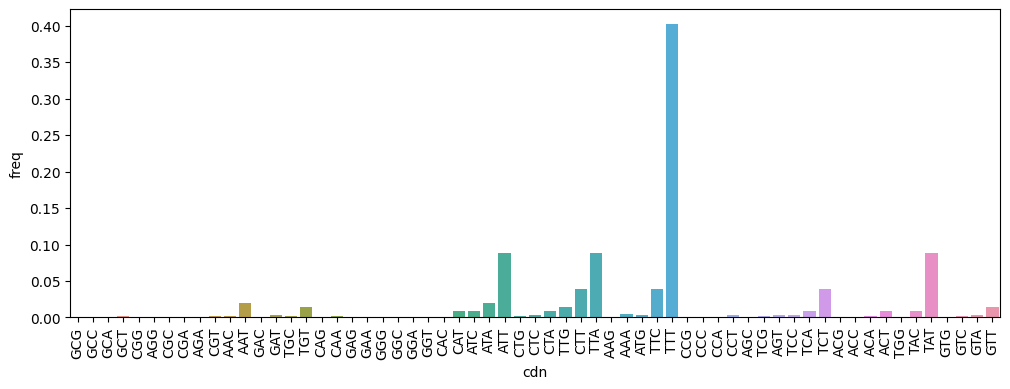

In [48]:
plt.figure(figsize=(12, 4))
sns.barplot(data=eq_freqs_cdn.sort_values(['aa', 'freq']).iloc[3:], 
            y='freq', x='cdn', )
plt.xticks(rotation=90);

In [60]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.to_csv('./data/aa_eq_freqs.csv', index=False)
eq_freqs_aa.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
aa,Phe,Leu,Ile,Tyr,Ser,Asn,Val,Cys,Thr,His,Pro,Lys,Asp,Met,Arg,Gln,Ala,Glu,Gly,Trp
freq,0.453163,0.160812,0.119522,0.099586,0.058378,0.021885,0.020914,0.016945,0.012011,0.009731,0.005341,0.005127,0.003724,0.003392,0.002916,0.00228,0.002044,0.000872,0.000782,0.000577


## Load OBS

In [37]:
# https://media.githubusercontent.com/media/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/mutation_counts/aggregated.csv
obs = pd.read_csv('data/aggregated.csv')
obs = obs[(obs['subset'] == 'all') & (obs['synonymous'] == False) & (obs['exclude'] == False)]

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)
obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# # obs['Mut'] = obs['mut_type'].str.replace('to', '>')
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate,aa1,aa2
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,62,16466,C,C,False,NaN,19A,all,2,False,P,L
1,M,I82T,T26767C,ATC>ACC,False,54,26767,T,T,False,NaN,19A,all,2,False,I,T
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,46,19220,C,C,False,NaN,19A,all,2,False,A,V
4,ORF1ab,I5658V,A17236G,ATA>GTA,False,45,17236,A,A,False,NaN,19A,all,1,False,I,V
5,ORF1ab,P4715L,C14408T,CCT>CTT,False,45,14408,C,C,False,NaN,19A,all,2,False,P,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979828,ORF1a;ORF1ab,T2756A;T2756A,A8531G,ACA>GCA;ACA>GCA,False,1,8531,A,A,False,NaN,22C,all,1,False,T,A
979829,ORF1a;ORF1ab,T2777A;T2777A,A8594G,ACA>GCA;ACA>GCA,False,1,8594,A,A,False,NaN,22C,all,1,False,T,A
979832,ORF1a;ORF1ab,T2825N;T2825N,C8739A,ACT>AAT;ACT>AAT,False,1,8739,C,C,False,NaN,22C,all,2,False,T,N
979833,ORF1a;ORF1ab,T2836A;T2836A,A8771G,ACA>GCA;ACA>GCA,False,1,8771,A,A,False,NaN,22C,all,1,False,T,A


In [135]:
obs_clade = obs[obs['clade'] == '20A']

aa_subst = obs_clade.groupby(['aa1', 'aa2'])['count'].sum().rename('nobs').reset_index()
aa_subst['aa1'] = aa_subst['aa1'].map(amino_acid_codes)
aa_subst['aa2'] = aa_subst['aa2'].map(amino_acid_codes)
aa_subst = aa_subst[(aa_subst.aa1 != aa_subst.aa2) & (aa_subst.aa1 != '*') & (aa_subst.aa2 != '*')]
aa_subst = aa_subst.merge(exp_aa_subst.rename(columns={'rate': 'rate_exp'}), 'right').fillna(0)
aa_subst = aa_subst[aa_subst['aa1'] != aa_subst['aa2']]
aa_subst['nexp'] = aa_subst.rate_exp / aa_subst.rate_exp.sum() * aa_subst.nobs.sum()
aa_subst['diff'] = aa_subst.nobs - aa_subst.nexp
aa_subst['nobs_freqs'] = aa_subst.nobs / aa_subst.nobs.sum()
aa_subst['nexp_freqs'] = aa_subst.nexp / aa_subst.nexp.sum()
aa_subst['clade'] = '20A'
aa_subst

,aa1,aa2,nobs,rate_exp,nexp,diff,nobs_freqs,nexp_freqs,clade
1,Ala,Asp,108.0,0.287620,74.078845,33.921155,0.001850,0.001269,20A
2,Ala,Glu,20.0,0.287620,74.078845,-54.078845,0.000343,0.001269,20A
3,Ala,Gly,23.0,0.220588,56.814214,-33.814214,0.000394,0.000973,20A
4,Ala,Pro,41.0,0.490200,126.254954,-85.254954,0.000702,0.002162,20A
5,Ala,Ser,1814.0,9.553600,2460.606550,-646.606550,0.031067,0.042141,20A
...,...,...,...,...,...,...,...,...,...
162,Val,Gly,73.0,0.180680,46.535588,26.464412,0.001250,0.000797,20A
163,Val,Ile,1055.0,2.246160,578.516581,476.483419,0.018068,0.009908,20A
164,Val,Leu,1281.0,5.267000,1356.558229,-75.558229,0.021939,0.023233,20A
165,Val,Met,121.0,0.748720,192.838860,-71.838860,0.002072,0.003303,20A


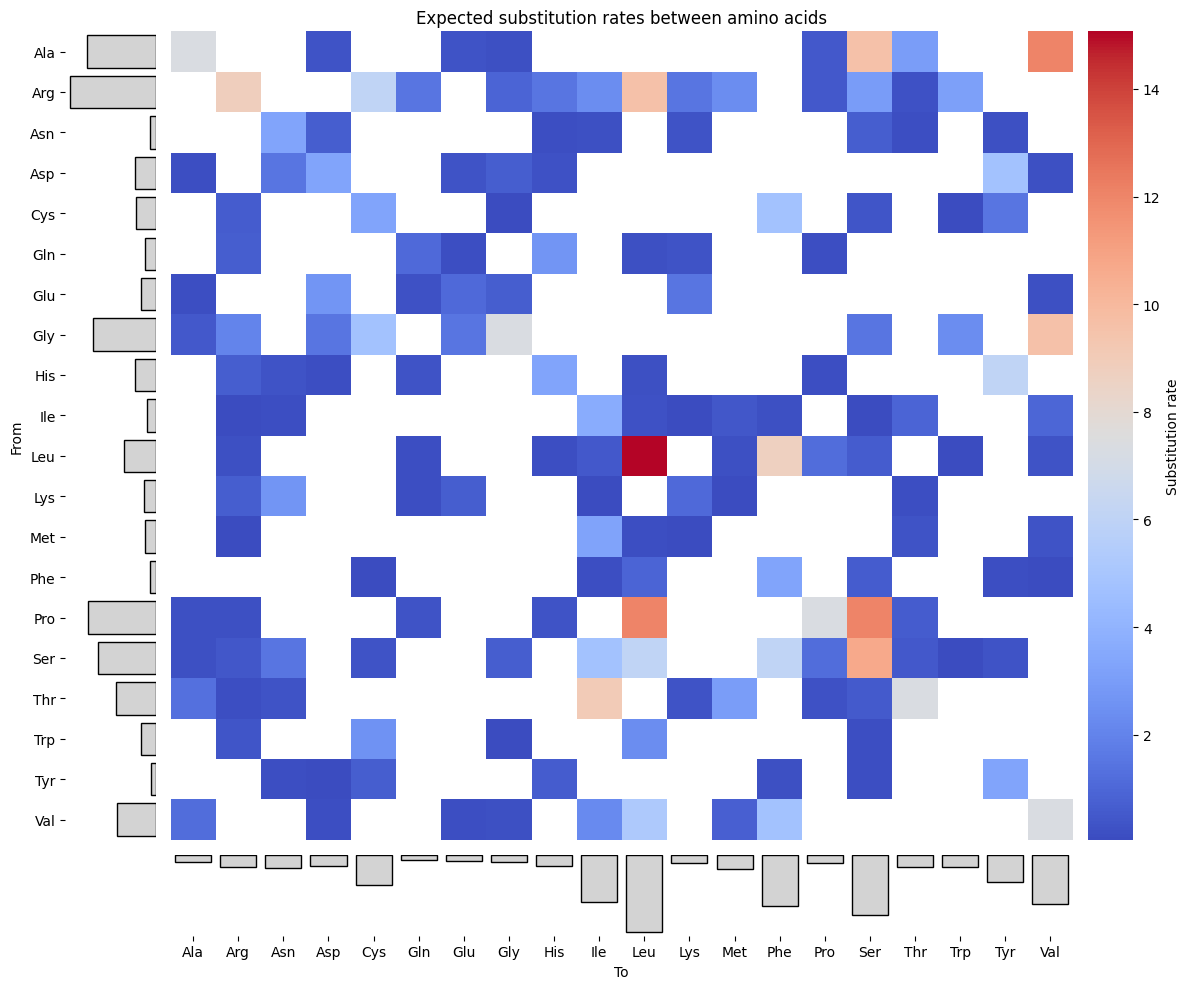

In [131]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10), 
                        width_ratios=[0.1, 1, .05], height_ratios=[1, 0.1])
sns.heatmap(exp_aa_subst_matrix, annot=False, fmt=".2f", ax=axs[0, 1], cbar_ax=axs[0, 2],
            cmap='coolwarm', cbar_kws={'label': 'Substitution rate'}, mask=exp_aa_subst_matrix==0,
)
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlabel('')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].set_title('Expected substitution rates between amino acids')


freqs_from = exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()
sns.barplot(freqs_from.reset_index(), y='aa1', x=0, ax=axs[0, 0],
            color='lightgray', edgecolor='black')
axs[0, 0].set_ylabel('From')
axs[0, 0].set_xlabel('')
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)
axs[0, 0].spines['bottom'].set_visible(False)
axs[0, 0].spines['left'].set_visible(False)
axs[0, 0].invert_xaxis()
axs[0, 0].set_xticks([])


freqs_to = exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()
sns.barplot(freqs_to.reset_index(), x='aa2', y=0, ax=axs[1, 1],
            color='lightgray', edgecolor='black')
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlabel('To')
axs[1, 1].spines['top'].set_visible(False)
axs[1, 1].spines['right'].set_visible(False)
axs[1, 1].spines['bottom'].set_visible(False)
axs[1, 1].spines['left'].set_visible(False)
axs[1, 1].invert_yaxis()
axs[1, 1].set_yticks([])

axs[1, 0].remove()
axs[1, 2].remove()

plt.tight_layout()
# plt.savefig('figures/exp_exp_aa_subst_matrix.pdf')
plt.show()

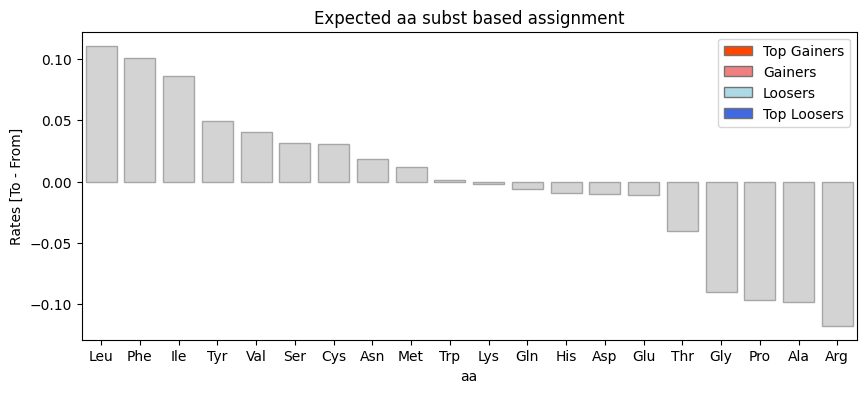

In [115]:
THRESHOLD = 0.5

_freqs_to = freqs_to / freqs_to.sum()
_freqs_from = freqs_from / freqs_from.sum()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

plt.figure(figsize=(10, 4))
sns.barplot((_freqs_to - _freqs_from).sort_values(ascending=False).reset_index(), 
            x='aa', y=0, color='lightgray', edgecolor=".65")

# for bar in ax.patches:
    # if bar.get_height() > 0.05:
    #     bar.set_color('orangered')
    #     bar.set_edgecolor('0.02')
    # elif bar.get_height() > THRESHOLD:
    #     bar.set_color('lightcoral')
    #     bar.set_edgecolor('0.05')
    # elif bar.get_height() < -1.5:
    #     bar.set_color('royalblue')
    #     bar.set_edgecolor('0.02')
    # elif bar.get_height() < -THRESHOLD:
    #     bar.set_color('lightblue')
    #     bar.set_edgecolor('0.45')

plt.legend([
    plt.Rectangle((0,0),1,1,fc="orangered", edgecolor = '0.45'), 
    plt.Rectangle((0,0),1,1,fc="lightcoral", edgecolor = '0.45'), 
    plt.Rectangle((0,0),1,1,fc='lightblue', edgecolor = '0.45'),
    plt.Rectangle((0,0),1,1,fc='royalblue', edgecolor = '0.45'),
    ],[
        'Top Gainers', 'Gainers', 'Loosers', 'Top Loosers'], 
    loc='upper right')

plt.title(f'Expected aa subst based assignment')
plt.ylabel('Rates [To - From]')
# plt.savefig('./figures/aa_diff_rates_vert_cytb.pdf')
plt.show()

In [116]:
obs_clade 

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate,aa1,aa2
10577,ORF1ab,K6958R,A21137G,AAG>AGG,False,141,21137,A,A,False,NaN,20A,all,2,False,K,R
10578,ORF1a;ORF1ab,K3353R;K3353R,A10323G,AAG>AGG;AAG>AGG,False,141,10323,A,A,False,NaN,20A,all,2,False,K,R
10579,ORF8,I121L,A28254C,ATC>CTC,False,121,28254,A,A,False,NaN,20A,all,1,False,I,L
10582,ORF3a,R172G,C25906G,CGT>GGT,False,93,25906,G,G,False,NaN,20A,all,1,False,R,G
10584,ORF1a;ORF1ab,V3261I;V3261I,G10046A,GTT>ATT;GTT>ATT,False,89,10046,G,G,False,NaN,20A,all,1,False,V,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35373,ORF1a;ORF1ab,T1721P;T1721P,A5426C,ACA>CCA;ACA>CCA,False,1,5426,A,A,False,NaN,20A,all,1,False,T,P
35374,ORF1a;ORF1ab,T1760A;T1760A,A5543G,ACA>GCA;ACA>GCA,False,1,5543,A,A,False,NaN,20A,all,1,False,T,A
35377,ORF1a;ORF1ab,T1788K;T1788K,C5628A,ACG>AAG;ACG>AAG,False,1,5628,C,C,False,NaN,20A,all,2,False,T,K
35378,ORF1a;ORF1ab,T1794A;T1794A,A5645G,ACA>GCA;ACA>GCA,False,1,5645,A,A,False,NaN,20A,all,1,False,T,A


In [159]:
aa_subst

,aa1,aa2,nobs,rate_exp,nexp,diff,nobs_freqs,nexp_freqs,clade
1,Ala,Asp,108.0,0.287620,74.078845,33.921155,0.001850,0.001269,20A
2,Ala,Glu,20.0,0.287620,74.078845,-54.078845,0.000343,0.001269,20A
3,Ala,Gly,23.0,0.220588,56.814214,-33.814214,0.000394,0.000973,20A
4,Ala,Pro,41.0,0.490200,126.254954,-85.254954,0.000702,0.002162,20A
5,Ala,Ser,1814.0,9.553600,2460.606550,-646.606550,0.031067,0.042141,20A
...,...,...,...,...,...,...,...,...,...
162,Val,Gly,73.0,0.180680,46.535588,26.464412,0.001250,0.000797,20A
163,Val,Ile,1055.0,2.246160,578.516581,476.483419,0.018068,0.009908,20A
164,Val,Leu,1281.0,5.267000,1356.558229,-75.558229,0.021939,0.023233,20A
165,Val,Met,121.0,0.748720,192.838860,-71.838860,0.002072,0.003303,20A


In [160]:
aa_subst[['nobs', 'nexp']].min(axis=1)

1        74.078845
2        20.000000
3        23.000000
4        41.000000
5      1814.000000
          ...     
162      46.535588
163     578.516581
164    1281.000000
165     121.000000
166    1230.303275
Length: 150, dtype: float64

In [161]:
def calc_accuracy(aa_subst):
    '''Acc = Sum(TP1, TP2, …, TPn)/total_obs_cnt'''
    TP = aa_subst[['nobs', 'nexp']].min(axis=1)
    total_obs_cnt = aa_subst['nobs'].sum()
    acc = TP.sum() / total_obs_cnt
    return acc

def calc_f1(aa_subst):
    '''Acc = Sum(TP1, TP2, …, TPn)/total_obs_cnt'''
    f1_weighted = 0.
    f1_macro = 0.
    total = aa_subst['nobs'].sum()
    n = len(aa_subst)

    for i, row in aa_subst.iterrows():
        o, e = row['nobs'], row['nexp']
        if o < e:
            tp = o
            fp = e - o
            fn = 0
        elif o > e:
            tp = e
            fp = 0
            fn = o - e
        else:
            tp = o
            fp = fn = 0

        f1 = (2 * tp) / (2 * tp + fp + fn)

        f1_macro += f1 / n
        f1_weighted += f1 * (o / total)

    return f1_macro, f1_weighted

In [162]:
def calc_metrics(aa_subst: pd.DataFrame):

    # 2. Сравним наблюдаемые и ожидаемые каунты с помощью критерия χ²
    chi2_stat, chi2_p = chisquare(aa_subst.nobs, aa_subst.nexp)

    # 2. Критерий Колмогорова-Смирнова
    ks_stat, ks_p = ks_2samp(aa_subst.nobs, aa_subst.nexp)

    # 3. Логарифмическое правдоподобие (Log-Likelihood)
    log_likelihood = np.sum(aa_subst.nobs_freqs * np.log(aa_subst.nexp_freqs) + \
                                (1 - aa_subst.nobs_freqs) * np.log(1 - aa_subst.nexp_freqs))

    # 4. Среднеквадратичная ошибка (MSE)
    rmse = mean_squared_error(aa_subst.nobs, aa_subst.nexp) ** 0.5

    # 5. Корреляция Спирмена
    spearman_corr, spearman_p = spearmanr(aa_subst.nobs, aa_subst.nexp)

    # 6. KL-дивергенция
    kl_divergence = np.sum(kl_div(aa_subst.nobs_freqs, 
                                aa_subst.nexp_freqs))

    # 7. Бутстреп-тест (пример)
    def bootstrap_test(observed, expected, n_iterations=1000):
        differences = observed - expected
        bootstrap_samples = np.random.choice(differences, size=(n_iterations, len(differences)), replace=True)
        bootstrap_means = np.mean(bootstrap_samples, axis=1)
        observed_mean_diff = np.mean(differences)
        p_value = np.mean(bootstrap_means >= observed_mean_diff)
        return p_value

    bootstrap_p = bootstrap_test(aa_subst.nobs, aa_subst.nexp)

    total_counts = np.sum(aa_subst.nobs)  # Общее число замещений

    acc = calc_accuracy(aa_subst)
    f1_macro, f1_weighted = calc_f1(aa_subst)

    metrics = {
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'log_likelihood': log_likelihood,
        'rmse': rmse,
        'rmse_scaled': rmse / total_counts,
        'spearman_corr': spearman_corr,
        'spearman_p': spearman_p,
        'kl_divergence': kl_divergence,
        'bootstrap_p': bootstrap_p,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'total_counts': total_counts,
    }
    return metrics

calc_metrics(aa_subst)

{'ks_stat': 0.1,
 'ks_p': 0.4425235033915137,
 'log_likelihood': -5.276538702417076,
 'rmse': 506.03502333621503,
 'rmse_scaled': 0.008666467260424988,
 'spearman_corr': 0.8094545517840136,
 'spearman_p': 4.839445759915626e-36,
 'kl_divergence': 0.27297812135086064,
 'bootstrap_p': 0.491,
 'accuracy': 0.7157836123867317,
 'f1_macro': 0.6820004801862186,
 'f1_weighted': 0.7336960817248331,
 'total_counts': 58390.0}

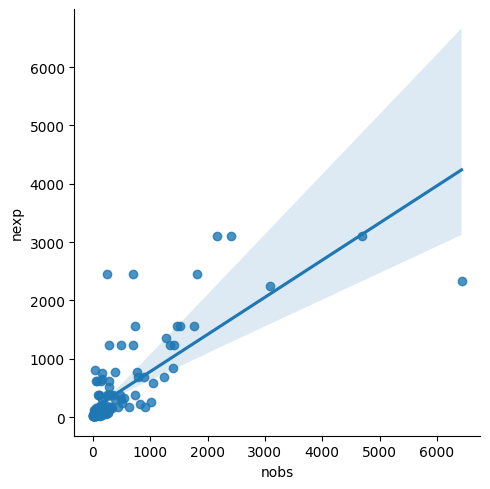

In [137]:
sns.lmplot(aa_subst, x='nobs', y='nexp')

/home/kpotoh/sars-cov-2/.venv/lib/python3.9/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/kpotoh/sars-cov-2/.venv/lib/python3.9/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


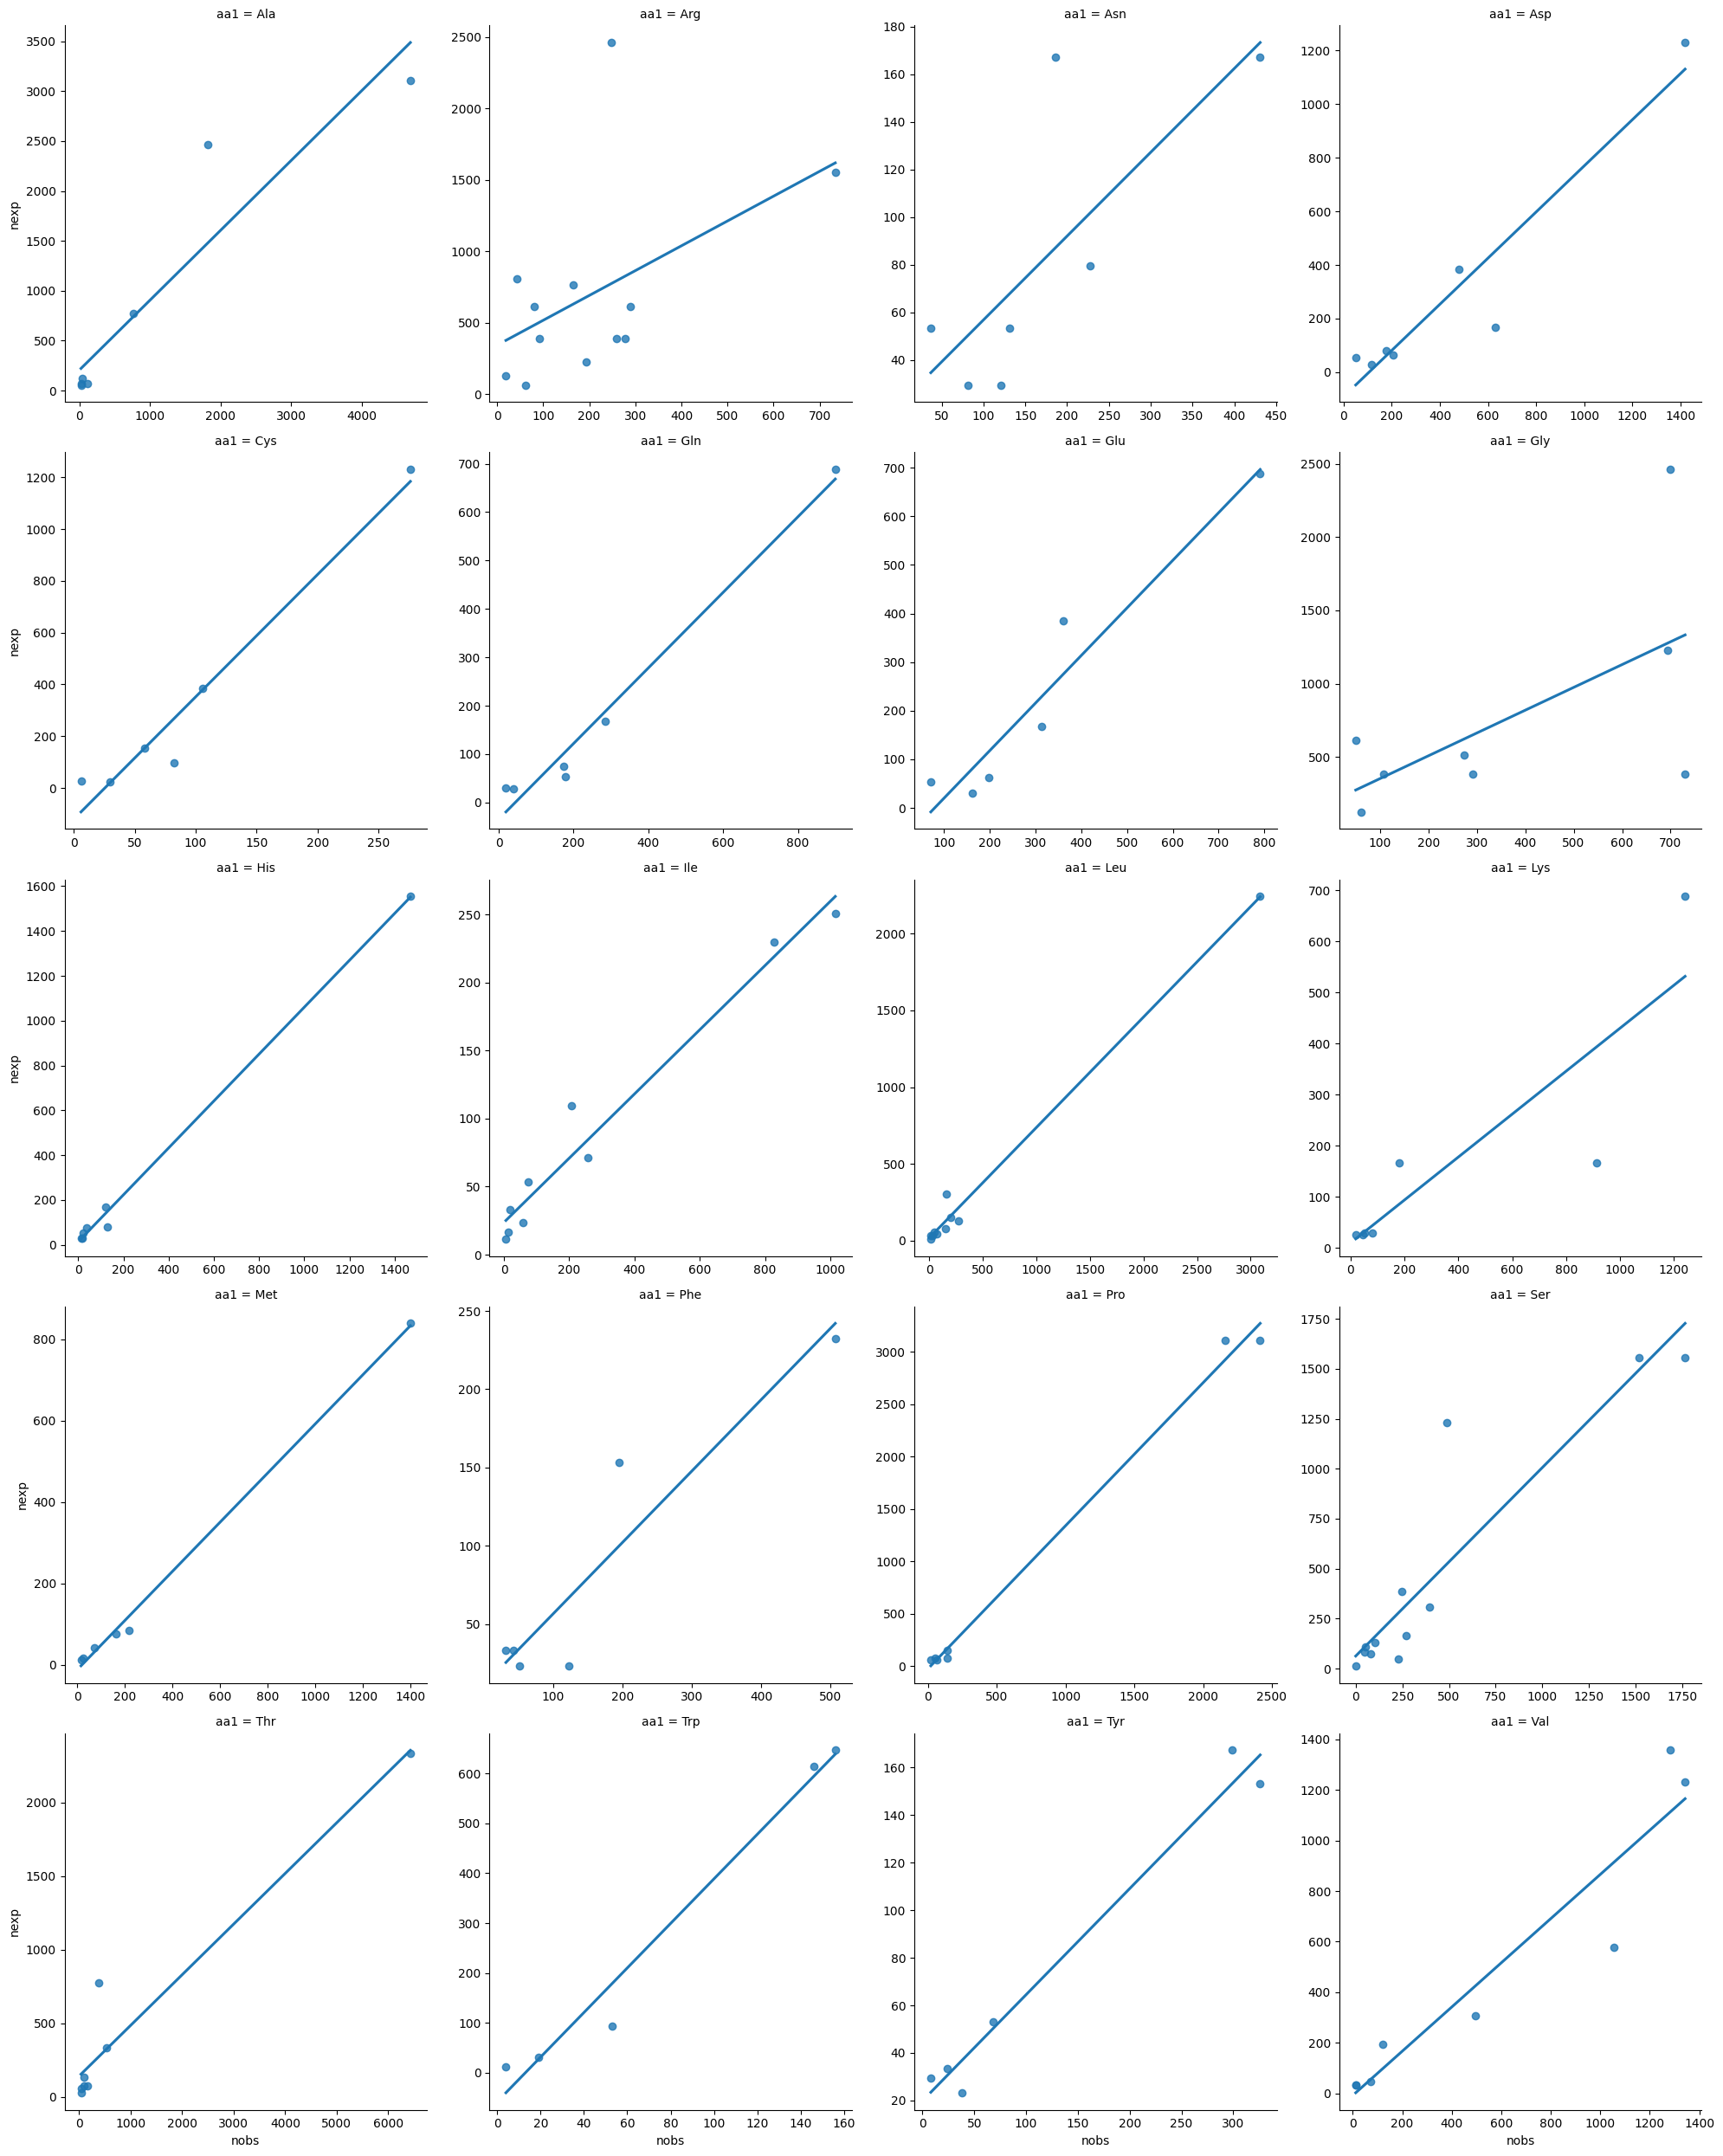

In [139]:
sns.lmplot(aa_subst, x='nobs', y='nexp', col='aa1',
           col_wrap=4, sharex=False, sharey=False, ci=None)

## Clade specific analysis

In [228]:
SAMPLE_CUTOFF = 0.10


metrics_total = []
for clade in clades_spectra.clade.unique():
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade]

    df_changes = collect_possible_changes(gc=1)
    clade_specific_spectrum = spectrum_20A.set_index('Mut').rate.to_dict()

    df_changes['rate'] = df_changes['sbs'].map(clade_specific_spectrum)

    df_changes['aa1'] = df_changes['aa1'].map(amino_acid_codes)
    df_changes['aa2'] = df_changes['aa2'].map(amino_acid_codes)

    ## Calculate expected AA substitutions matrix
    exp_aa_subst = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
    exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)

    ## Calculate codon and AA equilibrium frequencies
    cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
    M = cdn_spectrum_to_matrix(cdn_sbs)
    eq_prob = get_equilibrium_probabilities(M).astype(float)

    eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))

    eq_freqs_cdn.name = 'freq'
    eq_freqs_cdn.index.name = 'cdn'
    eq_freqs_cdn = eq_freqs_cdn.reset_index()
    eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

    obs_clade = obs[obs['clade'] == clade]
    print(clade, 'nmut', len(obs_clade))

    site_rates = obs_clade.groupby('nt_site')['count'].sum()
    nsites_total = len(site_rates)
    nsites_to_sample = int(nsites_total * SAMPLE_CUTOFF)
    top_rated_sites = site_rates[site_rates >= site_rates.quantile(1 - SAMPLE_CUTOFF)]\
        .sample(nsites_to_sample, replace=False).sort_index().index.values
    bottom_rated_sites = site_rates[site_rates <= site_rates.quantile(SAMPLE_CUTOFF)]\
        .sample(nsites_to_sample, replace=False).sort_index().index.values
    assert bottom_rated_sites.shape == top_rated_sites.shape

    obs_clade_most_variable_sites  = obs_clade[obs_clade.nt_site.isin(top_rated_sites)]
    obs_clade_least_variable_sites = obs_clade[obs_clade.nt_site.isin(bottom_rated_sites)]

    for df_obs, label in zip([obs_clade, obs_clade_most_variable_sites, obs_clade_least_variable_sites],
                             ['total', 
                              f'{SAMPLE_CUTOFF*100:.0f}% most variable', 
                              f'{SAMPLE_CUTOFF*100:.0f}% least variable']):
        
        aa_subst = df_obs.groupby(['aa1', 'aa2'])['count'].sum().rename('nobs').reset_index()
        aa_subst['aa1'] = aa_subst['aa1'].map(amino_acid_codes)
        aa_subst['aa2'] = aa_subst['aa2'].map(amino_acid_codes)
        aa_subst = aa_subst[(aa_subst.aa1 != aa_subst.aa2) & (aa_subst.aa1 != '*') & (aa_subst.aa2 != '*')]
        aa_subst = aa_subst.merge(exp_aa_subst.rename(columns={'rate': 'rate_exp'}), 'right').fillna(0)
        aa_subst = aa_subst[aa_subst['aa1'] != aa_subst['aa2']]
        aa_subst['nexp'] = aa_subst.rate_exp / aa_subst.rate_exp.sum() * aa_subst.nobs.sum()
        aa_subst['diff'] = aa_subst.nobs - aa_subst.nexp
        aa_subst['nobs_freqs'] = aa_subst.nobs / aa_subst.nobs.sum()
        aa_subst['nexp_freqs'] = aa_subst.nexp / aa_subst.nexp.sum()

        cur_metrics = calc_metrics(aa_subst)
        cur_metrics['clade'] = clade
        cur_metrics['sites_sample'] = label
    
        metrics_total.append(cur_metrics)

20A nmut 15602
20B nmut 13715
20C nmut 11055
20E nmut 11742
20G nmut 13357
20I nmut 26147
21C nmut 8487
21I nmut 18318
21J nmut 43782
21K nmut 31741
21L nmut 26958
22A nmut 10680
22B nmut 24101
22C nmut 14454


In [229]:
metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'sites_sample'])
metrics_total_df.to_csv('data/clades_fit_metrics.csv', float_format='%g')
metrics_total_df

ks_stat          ks_p  log_likelihood         rmse  \
clade sites_sample                                                              
20A   total               0.100000  4.425235e-01       -5.276539   506.035023   
      10% most variable   0.313333  6.587400e-07       -4.824473   362.561191   
      10% least variable  0.246667  2.040625e-04       -6.455897    13.889485   
20B   total               0.093333  5.321869e-01       -5.276183   400.199071   
      10% most variable   0.286667  7.768915e-06       -4.813933   269.541413   
      10% least variable  0.286667  7.768915e-06       -6.477890    12.631274   
20C   total               0.120000  2.307824e-01       -5.289812   271.318036   
      10% most variable   0.340000  4.412944e-08       -4.824146   176.951444   
      10% least variable  0.240000  3.347341e-04       -6.348415    10.493488   
20E   total               0.113333  2.910740e-01       -5.191457   328.418306   
      10% most variable   0.433333  4.995525e-13       -4.601885   259.579040   
      10% least variable  0.220000  1.357878e-03       -6.425452    11.586182   
20G   total               0.093333  5.321869e-01       -5.231083   427.711383   
      10% most variable   0.346667  2.162780e-08       -4.694374   322.258472   
      10% least variable  0.240000  3.347341e-04       -6.407473    12.771731   
20I   total               0.100000  4.425235e-01       -5.205853  1951.953857   
      10% most variable   0.373333  1.072155e-09       -4.708365  1691.236910   
      10% least variable  0.206667  3.220729e-03       -6.649652    22.156353   
21C   total               0.100000  4.425235e-01       -5.231816   191.597098   
      10% most variable   0.426667  1.248881e-12       -4.675634   130.095092   
      10% least variable  0.273333  2.445506e-05       -6.256015     8.001239   
21I   total               0.126667  1.803948e-01       -5.327511   640.237058   
      10% most variable   0.340000  4.412944e-08       -4.823016   446.605810   
      10% least variable  0.253333  1.226546e-04       -6.623483    17.349025   
21J   total               0.113333  2.910740e-01       -5.322276  7629.184939   
      10% most variable   0.300000  2.329237e-06       -4.829901  6144.349019   
      10% least variable  0.166667  3.083896e-02       -6.728559    41.128014   
21K   total               0.133333  1.390622e-01       -5.380141  3249.430629   
      10% most variable   0.253333  1.226546e-04       -4.838732  2808.903935   
      10% least variable  0.233333  5.413960e-04       -6.660876    24.172033   
21L   total               0.106667  3.617269e-01       -5.362110  2387.613350   
      10% most variable   0.253333  1.226546e-04       -4.855956  2044.840542   
      10% least variable  0.226667  8.634332e-04       -6.667472    21.283988   
22A   total               0.120000  2.307824e-01       -5.330375   306.728283   
      10% most variable   0.346667  2.162780e-08       -4.796264   207.461210   
      10% least variable  0.213333  2.105861e-03       -6.385241    10.495095   
22B   total               0.113333  2.910740e-01       -5.348532  1786.331889   
      10% most variable   0.293333  4.284917e-06       -4.839710  1454.741046   
      10% least variable  0.180000  1.534428e-02       -6.670881    21.406488   
22C   total               0.093333  5.321869e-01       -5.324275   556.016657   
      10% most variable   0.360000  4.964596e-09       -4.745972   424.018941   
      10% least variable  0.226667  8.634332e-04       -6.460864    14.009971   

                          rmse_scaled  spearman_corr    spearman_p  \
clade sites_sample                                                   
20A   total                  0.008666       0.809455  4.839446e-36   
      10% most variable      0.012618       0.765614  3.760927e-30   
      10% least variable     0.012152       0.462525  2.541112e-09   
20B   total                  0.008527       0.793693  9.251149e-34   
      10% most variable      0.012493     

In [230]:
metrics_total_df[['total_counts', 'log_likelihood', 'spearman_corr', 'accuracy', 'f1_macro', 'f1_weighted']]

total_counts  log_likelihood  spearman_corr  \
clade sites_sample                                                      
20A   total                    58390.0       -5.276539       0.809455   
      10% most variable        28733.0       -4.824473       0.765614   
      10% least variable        1143.0       -6.455897       0.462525   
20B   total                    46932.0       -5.276183       0.793693   
      10% most variable        21575.0       -4.813933       0.720098   
      10% least variable        1042.0       -6.477890       0.454990   
20C   total                    31691.0       -5.289812       0.799776   
      10% most variable        13371.0       -4.824146       0.708169   
      10% least variable         880.0       -6.348415       0.542057   
20E   total                    34924.0       -5.191457       0.810193   
      10% most variable        15769.0       -4.601885       0.714544   
      10% least variable         941.0       -6.425452       0.474176   
20G   total                    45231.0       -5.231083       0.789795   
      10% most variable        21061.0       -4.694374       0.752859   
      10% least variable        1034.0       -6.407473       0.518316   
20I   total                   205188.0       -5.205853       0.816442   
      10% most variable       119624.0       -4.708365       0.790406   
      10% least variable        1618.0       -6.649652       0.364798   
21C   total                    20840.0       -5.231816       0.789595   
      10% most variable         8465.0       -4.675634       0.691247   
      10% least variable         714.0       -6.256015       0.579754   
21I   total                    80214.0       -5.327511       0.804066   
      10% most variable        39777.0       -4.823016       0.769475   
      10% least variable        1288.0       -6.623483       0.385292   
21J   total                   965925.0       -5.322276       0.812410   
      10% most variable       563353.0       -4.829901       0.787917   
      10% least variable        2852.0       -6.728559       0.273159   
21K   total                   341745.0       -5.380141       0.778014   
      10% most variable       190350.0       -4.838732       0.780399   
      10% least variable        1781.0       -6.660876       0.351755   
21L   total                   245921.0       -5.362110       0.781304   
      10% most variable       138106.0       -4.855956       0.774914   
      10% least variable        1619.0       -6.667472       0.356084   
22A   total                    31466.0       -5.330375       0.783024   
      10% most variable        13240.0       -4.796264       0.683447   
      10% least variable         867.0       -6.385241       0.507550   
22B   total                   189953.0       -5.348532       0.791072   
      10% most variable       103217.0       -4.839710       0.757846   
      10% least variable        1536.0       -6.670881       0.341509   
22C   total                    55848.0       -5.324275       0.780936   
      10% most variable        25766.0       -4.745972       0.722839   
      10% least variable        1099.0       -6.460864       0.475815   

                          accuracy  f1_macro  f1_weighted  
clade sites_sample                                         
20A   total               0.715784  0.682000     0.733696  
      10% most variable   0.669545  0.507986     0.701648  
      10% least variable  0.415491  0.368583     0.410644  
20B   total               0.716790  0.674509     0.735102  
      10% most variable   0.655701  0.473248     0.689467  
      10% least variable  0.420751  0.388798     0.413953  
20C   total               0.716419  0.679516     0.733669  
      10% most variable   0.653931  0.466031     0.691278  
      10% least variable  0.458570  0.441752     0.464230  
20E   total               0.715986  0.681564     0.737731  
      10% most variable   0.614825  0.379266     0.660891  
      10% least variable  0.41604

In [234]:
obs_clade['count'].sum()

56231